# Import Pakages

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns

from modules.dolphin_patterns import greedy_match, DOLPHIN_PATTERNS
from modules.feature_extraction import compute_phonics_features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


# Load and Overview Datasets

In [2]:
df = pd.read_csv('dga_data.csv')
df

,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker
...,...,...,...,...
159995,legit,manhunt,manhunt.net,alexa
159996,legit,yupptv,yupptv.com,alexa
159997,legit,bbcmundo,bbcmundo.com,legit
159998,legit,kanogames,kanogames.com,legit


In [3]:
print(df.describe())

         isDGA                      domain                 host subclass
count   160000                      159998               160000   160000
unique       2                      159998               159235        9
top        dga  6xzxsw3sokvg1tc752y1a6p0af  ventures-africa.com    alexa
freq     80000                           1                    2    42616


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   isDGA     160000 non-null  object
 1   domain    159998 non-null  object
 2   host      160000 non-null  object
 3   subclass  160000 non-null  object
dtypes: object(4)
memory usage: 4.9+ MB
None


# Preprocessing datasets

In [5]:
df.isna().sum()

isDGA       0
domain      2
host        0
subclass    0
dtype: int64

In [6]:
df.dropna()


,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker
...,...,...,...,...
159995,legit,manhunt,manhunt.net,alexa
159996,legit,yupptv,yupptv.com,alexa
159997,legit,bbcmundo,bbcmundo.com,legit
159998,legit,kanogames,kanogames.com,legit


In [7]:
df.drop(['domain'], axis=1, inplace=True)
df

,isDGA,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver.ru,cryptolocker
...,...,...,...
159995,legit,manhunt.net,alexa
159996,legit,yupptv.com,alexa
159997,legit,bbcmundo.com,legit
159998,legit,kanogames.com,legit


<Axes: xlabel='count', ylabel='isDGA'>

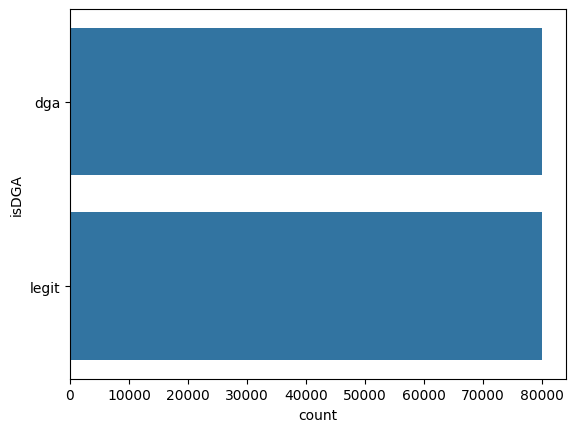

In [8]:
sns.countplot(df['isDGA'])

<Axes: xlabel='count', ylabel='subclass'>

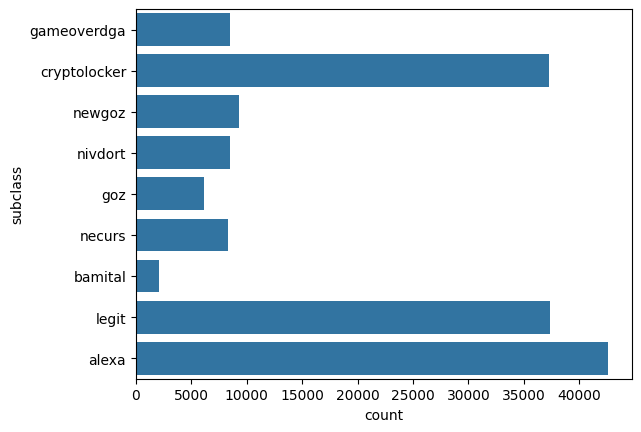

In [9]:
sns.countplot(df['subclass'])

# Label Encoding

In [10]:
df['isDGA'] = df['isDGA'].map({'dga': 1, 'legit': 0})
df

,isDGA,host,subclass
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,1,glbtlxwwhbnpxs.ru,cryptolocker
2,1,xxmamopyipbfpk.ru,cryptolocker
3,1,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,1,jpqftymiuver.ru,cryptolocker
...,...,...,...
159995,0,manhunt.net,alexa
159996,0,yupptv.com,alexa
159997,0,bbcmundo.com,legit
159998,0,kanogames.com,legit


# Extract Features

In [11]:
features = []
for _, row in df.iterrows():
    # Apply DOLPHIN pattern matching
    matches = greedy_match(row["host"], DOLPHIN_PATTERNS)
    
    # Compute phonics features
    phonics_features = compute_phonics_features(matches)

    # Add label to features
    phonics_features["isDGA"] = row["isDGA"]

    # Append to features list
    features.append(phonics_features)

# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df

,vowel_ratio,consonant_ratio,neutral_ratio,pattern_diversity,max_pattern_length,isDGA
0,0.137931,0.517241,0.344828,0.103448,2,1
1,0.066667,0.866667,0.066667,0.200000,2,1
2,0.235294,0.705882,0.058824,0.176471,1,1
3,0.137931,0.482759,0.379310,0.103448,1,1
4,0.285714,0.642857,0.071429,0.214286,2,1
...,...,...,...,...,...,...
159995,0.300000,0.600000,0.100000,0.300000,2,0
159996,0.200000,0.700000,0.100000,0.300000,1,0
159997,0.272727,0.636364,0.090909,0.272727,2,0
159998,0.384615,0.538462,0.076923,0.230769,1,0


# Train model

### Separate features and labels

In [12]:
X = features_df.drop('isDGA', axis=1)
y = features_df['isDGA']

### Create a pipeline for scaling and classification

In [70]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(         
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=None,
        min_samples_split=5
    ))
])

### Perform 5-fold cross-validation

In [71]:
cross_val_scores = cross_val_score(pipeline, X, y, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Average cross-validation score:", np.mean(cross_val_scores))

Cross-validation scores: [0.88815625 0.88684375 0.88971875 0.887375   0.89165625]
Average cross-validation score: 0.8887499999999999


### Train-test split for final evaluation

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [73]:
# Detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# FPR and FNR
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
fpr = fp / (fp + tn)
fnr = fn / (tp + fn)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Feature importance
rf_classifier = pipeline.named_steps['classifier']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.89     16000
           1       0.94      0.83      0.88     16000

    accuracy                           0.89     32000
   macro avg       0.89      0.89      0.89     32000
weighted avg       0.89      0.89      0.89     32000


Confusion Matrix:
[[15163   837]
 [ 2770 13230]]

Accuracy: 0.8873
False Positive Rate (FPR): 0.0523
False Negative Rate (FNR): 0.1731

Feature Importance:
              feature  importance
0         vowel_ratio    0.340816
3   pattern_diversity    0.335316
1     consonant_ratio    0.190602
2       neutral_ratio    0.101073
4  max_pattern_length    0.032193
